In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simsopt import load
from simsopt.field import CurrentPotentialFourier
from quadcoil import QuadcoilParams, SurfaceRZFourierJAX, quadcoil
from quadcoil.quantity.current import _K, _K_desc_unit
from quadcoil.quantity.force import _self_force_integrands_xyz
from quadcoil import norm_helper, project_arr_cylindrical

In [2]:
# Loading muse++ equilibrium into VMEC
# filename_pp = "wout_muse++.nc"
# equil_pp = Vmec(filename_pp, keep_all_files=True)
# plasma_surface = equil_pp.boundary
# net_poloidal_current_amperes = equil_pp.external_current()

# Loading NCSX
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
jax.config.update('jax_enable_x64', False)

In [3]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running nescoil, with auto-generated '\
      'winding surface.')
nescoil_out_dict, nescoil_qp, nescoil_dofs, _ = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    objective_weight=None,
    objective_unit=None,
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running nescoil, with auto-generated winding surface.


In [ ]:
qp = nescoil_qp
dofs = nescoil_dofs
skip_integral = False

In [9]:
(
    integrand_single_xyz,
    integrand_double_xyz
) = _self_force_integrands_xyz(qp, dofs)
gamma_1fp = qp.eval_surface.gamma()

In [ ]:
integrand_single_cylindrical = project_arr_cylindrical(
    gamma_1fp, 
    integrand_single_xyz
)
integrand_double_cylindrical = project_arr_cylindrical(
    gamma_1fp, 
    integrand_double_xyz
)
# The projection function assumes that the first 3 components of the array represents the 
# phi, theta grid and resulting components of the array. Hence the swapaxes.
integrand_single_cylindrical = project_arr_cylindrical(
    gamma_1fp, 
    integrand_single_cylindrical.swapaxes(2, 3) 
).swapaxes(2,3)
integrand_double_cylindrical = project_arr_cylindrical(
    gamma_1fp, 
    integrand_double_cylindrical.swapaxes(2, 3) 
).swapaxes(2,3)


In [22]:
# single-layer kernel
gamma_y = qp.eval_surface.gamma()
gamma_x = qp.winding_surface.gamma()
unitnormal_x = qp.winding_surface.unitnormal()

In [26]:
# Dims: n_phiy, n_thetay, n_phix, n_thetax, 3
diff = gamma_y[:, :, None, None, :] - gamma_x[None, None, :, :, :] 
dist = jnp.linalg.norm(diff, axis=-1)
double_layer_denom = jnp.sum(diff * unitnormal_x[None, None, :, :, :], axis=-1)

In [32]:
thres = 1e-8

In [33]:
double_layer_denom.shape

(32, 34, 96, 34)

In [37]:

single_layer_kernel = jnp.where(dist>thres, 1/dist, 0)
double_layer_kernel = jnp.where(dist>thres, double_layer_denom/(dist**3), 0)

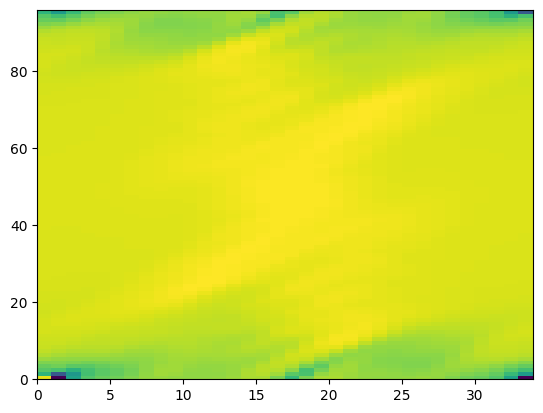

In [38]:
plt.pcolor(double_layer_kernel[0, 0, :, :])

In [13]:
single_layer_kernel.shape

(32, 34, 96, 34, 3)

In [8]:
integrand_single_cylindrical.shape

(32, 34, 3, 3)

In [ ]:
def self_force_cylindrical(cp: CurrentPotentialFourier, current_scale, normalize=True, skip_integral=False):
    winding_surface = cp.winding_surface
    nfp = cp.nfp
    len_phi_1fp = len(winding_surface.quadpoints_phi)//nfp
    # AK, bK = AK_helper(cp)
    # AK_trimmed = AK[:len_phi_1fp]
    # bK_trimmed = bK[:len_phi_1fp]
    # (
    #     K_x_op_xyz,
    #     integrand_single_xyz,
    #     integrand_double_xyz
    # ) = self_force_integrands_xyz(
    #     normal=winding_surface.normal()[:len_phi_1fp],
    #     unitnormal=winding_surface.unitnormal()[:len_phi_1fp],
    #     gammadash1=winding_surface.gammadash1()[:len_phi_1fp],
    #     gammadash2=winding_surface.gammadash2()[:len_phi_1fp],
    #     gammadash1dash1=winding_surface.gammadash1dash1()[:len_phi_1fp],
    #     gammadash1dash2=winding_surface.gammadash1dash2()[:len_phi_1fp],
    #     gammadash2dash2=winding_surface.gammadash2dash2()[:len_phi_1fp],
    #     nfp=nfp, 
    #     cp_m=cp.m, 
    #     cp_n=cp.n,
    #     net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    #     net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    #     quadpoints_phi=winding_surface.quadpoints_phi[:len_phi_1fp],
    #     quadpoints_theta=winding_surface.quadpoints_theta,
    #     stellsym=winding_surface.stellsym,
    #     AK_x_trimmed=AK_trimmed, 
    #     bK_x_trimmed=bK_trimmed,
    #     current_scale=current_scale
    # )

    # gamma_1fp = winding_surface.gamma()[:len_phi_1fp]
    # # We must perform the xyz -> R,Phi,Z coordinate change twice for both
    # # axis 2 and 3. Otherwise the operator will not have 
    # # the same nfp-fold discrete symmetry as the equilibrium. 
    # integrand_single_cylindrical = project_arr_cylindrical(
    #     gamma_1fp, 
    #     integrand_single_xyz
    # )
    # integrand_double_cylindrical = project_arr_cylindrical(
    #     gamma_1fp, 
    #     integrand_double_xyz
    # )
    # # The projection function assumes that the first 3 components of the array represents the 
    # # phi, theta grid and resulting components of the array. Hence the swapaxes.
    # integrand_single_cylindrical = project_arr_cylindrical(
    #     gamma_1fp, 
    #     integrand_single_cylindrical.swapaxes(2, 3) 
    # ).swapaxes(2,3)
    # integrand_double_cylindrical = project_arr_cylindrical(
    #     gamma_1fp, 
    #     integrand_double_cylindrical.swapaxes(2, 3) 
    # ).swapaxes(2,3)

    # K_op_cylindrical = project_arr_cylindrical(
    #     gamma_1fp, 
    #     K_x_op_xyz
    # )

    if skip_integral:
        return(K_op_cylindrical, integrand_single_cylindrical, integrand_double_cylindrical)

    # Performing the singular integral using BIEST
    integrand_single_cylindrical_reshaped = integrand_single_cylindrical.reshape((
        integrand_single_cylindrical.shape[0],
        integrand_single_cylindrical.shape[1],
        -1
    ))
    integrand_double_cylindrical_reshaped = integrand_double_cylindrical.reshape((
        integrand_double_cylindrical.shape[0],
        integrand_double_cylindrical.shape[1],
        -1
    ))
    result_single = np.zeros_like(integrand_single_cylindrical_reshaped)
    result_double = np.zeros_like(integrand_double_cylindrical_reshaped)
    biest_call.integrate_multi(
        gamma_1fp, # xt::pyarray<double> &gamma,
        integrand_single_cylindrical_reshaped, # xt::pyarray<double> &func_in_single,
        result_single, # xt::pyarray<double> &result,
        True,
        10, # int digits,
        nfp, # int nfp
    )
    biest_call.integrate_multi(
        gamma_1fp, # xt::pyarray<double> &gamma,
        integrand_double_cylindrical_reshaped, # xt::pyarray<double> &func_in_single,
        result_double, # xt::pyarray<double> &result,
        False,
        10, # int digits,
        nfp, # int nfp
    )
    # BIEST's convention has an extra 1/4pi.
    # We remove it now, and reshape the output 
    # into [n_phi(y), n_theta(y), 3(operates on K_y), 3, ndof].
    result_single = 4 * np.pi * result_single.reshape(
        result_single.shape[0],
        result_single.shape[1],
        3, 3, -1
    )
    # BIEST's convention has an extra 1/4pi.
    # We remove it now, and reshape the output 
    # into [n_phi(y), n_theta(y), 3(operates on K_y), 3, ndof].
    result_double = 4 * np.pi * result_double.reshape(
        result_double.shape[0],
        result_double.shape[1],
        3, 3, -1
    )
    # The final operator
    # [n_phi(y), n_theta(y), 3, ndof]
    # The negative sign is added by BIEST (NEED CONFIRMATION)
    self_force_cylindrical_operator = np.sum(
        K_op_cylindrical[:, :, :, None, :, None] 
        * (result_single - result_double)[:, :, :, :, None, :],
        axis = 2
    )
    
    if normalize:
        self_force_scale = avg_order_of_magnitude(self_force_cylindrical_operator)
        self_force_cylindrical_operator /= self_force_scale
    else:
        self_force_scale = 1
    return(self_force_cylindrical_operator, self_force_scale)
